In [1]:
%load_ext autotime

In [6]:
import numpy as np
from numba import jit
import matplotlib.pyplot as pl
from scipy import optimize

time: 750 µs


In [7]:
def fit (r, a, b):
    return b * 1/(r**a)

time: 972 µs


In [8]:
def fit_log(r, a, b):
    return a*r + b

time: 2.62 ms


In [5]:
def init_bonds(Lx, Ly):
    bonds = np.ones(2*Lx*Ly, dtype = np.intp)
    
    H, V = 2*Lx, Ly
    bond_coord = np.zeros((Lx, Ly, 4), dtype = np.intp)
    next_xyprev = np.zeros((Lx, Ly, 4, 3), dtype = np.intp)
    
    for x in range(Lx):
        for y in range(Ly):
            bond_coord[x, y] = [2*x*Ly+y, ((2*x-1)% H)*Ly + y, 2*x*Ly + ((y-1) % V), ((2*x+1) % H)*Ly + y]
            
            for sel in range(4):
                if sel % 2 == 0:              #If selected index is even -> Move vertically
                    x_ = x                   
                    y_ = (y + 1 - sel) % Ly   #Move up if 0, move down if 2
                else:                        #If selected index is odd -> Move horizontally
                    x_ = (x + sel - 2) % Lx   #Move left if 1, move right if 3
                    y_ = y
                    
                prev = (sel + 2) % 4         # 0 <-> 2, 1 <-> 3
                next_xyprev[x, y, sel] = (x_, y_, prev)
    
    return bonds, bond_coord, next_xyprev 

time: 2.69 ms


In [8]:
#Conversions for bond coordinates
def xy_to_n(x,y,Ly):    # x from 0 to 2*Lx-1, y from 0 to Ly-1
    return x*Ly + y

def n_to_xy(n,Ly):
    return n // Ly , n % Ly

#Distance between two bonds with PBC in site coordinates unit length   
def r_from_n(n1, n2, Lx, Ly):   
    x1, y1 = n_to_xy(n1, Ly)
    x2, y2 = n_to_xy(n2, Ly)
    dx = (x2 - x1) / 2          #Bond coordinates -> Site coordinates 
    dy = y2 - y1
    if np.abs(dx) > Lx / 2:     #Account for PBC
        dx = dx - np.sign(dx) * Lx
    if np.abs(dy) > Ly /2:
        dy = dy - np.sign(dy) * Ly
    
    return np.sqrt(dx**2+ dy**2)

time: 2.95 ms


In [9]:
def random_defect(bonds, bond_coord, next_xyprev, Lx, Ly):
    x0 = np.random.randint(Lx)
    y0 = np.random.randint(Ly)
    #print('First site:', (x0,y0))
    
    site = bonds_on_site(x0, y0, bonds, bond_coord, Lx, Ly)
    sel = np.random.randint(4)
    
    bonds[bond_coord[x0, y0, sel]]  *= -1  #Switch selected bond
    #print('Started with bond n=',bond_coord[sel])
    
    x, y, prev = next_xyprev[x0, y0, sel]
    
    return x, y, prev, bonds, x0, y0

time: 3.53 ms


In [13]:
@jit(nopython= True)
def bonds_on_site(x, y, bonds, bond_coord, Lx, Ly):
    coord = bond_coord[x,y]
    out = bonds[coord] * np.array([-1, 1, 1, -1])
    return out

time: 1.56 ms


In [14]:
@jit(nopython= True)
def which_way(x, y, prev, bonds, bond_coord, next_xyprev, Lx, Ly):
    site = bonds_on_site(x, y, bonds, bond_coord, Lx, Ly)
    
    xtra = np.sum(site)    #Should I change a -1 or a +1 bond? Xtra can be 2 or -2
    
    if xtra == 0:                 #There are no more defects, we should stop
        return x, y, -1, bonds    #prev = -1 -> stop update, the stable bond configuration is returned
    
    site[prev] = 0         #The previous site cannot be changed back (value 0 has no meaning)
    options = np.array([0,1,2,3])[site == xtra//2]
    sel = np.random.choice(options)    #Randomly choose one of them
    
    coord = bond_coord[x, y, sel]
    bonds[coord]  *= -1  #Switch selected bond
    
    x, y, prev = next_xyprev[x, y, sel]
    
    return x, y, prev, bonds
    

time: 3.07 ms


In [15]:
@jit
def run_worm(bonds, bond_coord, next_xyprev, Lx, Ly):
    x, y, prev, bonds, x0, y0 = random_defect(bonds, bond_coord, next_xyprev, Lx, Ly)
    
    while prev != -1:
        x, y, prev, bonds = which_way(x, y, prev, bonds, bond_coord, next_xyprev, Lx, Ly)
    
    assert (x0, y0) == (x,y)
    
    return bonds

time: 1.47 ms


In [16]:
@jit(nopython=True)
def measure(i, bonds, n0s, N_total, len_A, Corr_bins):
    for j in range(len_A):
        n0_ = n0s[j]
        for ind, n in enumerate(N_total[j]):
            Corr_bins[j, i, ind] = bonds[n0_]*bonds[n]
    return Corr_bins

time: 2.43 ms


In [19]:
def calculate_correlations(Corr_bins, Rs, len_A):
    Corrs_total_bin = []
    N_rs = len(Rs)
    for j in range(len_A):
        Corrs = []
        corr_bin = Corr_bins[j]
        for r in range(N_rs):
            Corrs.append([np.mean(corr_bin[:,r]), np.std(corr_bin[:,r]) / np.sqrt( len(corr_bin) )])
            
        Corrs_total_bin.append(Corrs)
    
    Corrs_total_bin = np.array(Corrs_total_bin)
    
    Corrs_out = []
    for r in range(N_rs):
        Corrs_out.append([np.mean(Corrs_total_bin[:,r,0]), np.mean(Corrs_total_bin[:,r,1])])
    
    return np.array(Corrs_out)

time: 3.61 ms


In [20]:
def run_simulation(Lx, Ly, N_iter = 1000, n0 = 0, run_all = False,
                   max_size = 100, diag = False, inv = False):
    bonds, bond_coord, next_xyprev = init_bonds(Lx, Ly)
    assert n0 < 2*Lx*Ly
    x0, y0 = n_to_xy(n0, Ly)
    direct = x0 % 2    # x even -> vertical spin -> direct=0; x odd -> horizontal -> direct=1 
    
    As = []
    if run_all:
        for x in range(Lx):
            for y in range(Ly):
                As.append([x,y])
    else:
        As = [[0,0]]
    
    if diag:
        L = np.min([Lx, Ly])
        N_rs = L//2
    
    else:
        if direct == 0:
            N_rs = Ly//2
        if direct == 1:
            N_rs = Lx//2
        
    while True:
        if len(As) > max_size:
            new_As = []
            chosen = np.random.choice(np.arange(len(As), dtype=np.int64),
                                      size = max_size, replace = False)
            for i in chosen:
                new_As.append(As[i])
        
            As = new_As
        try:
            Corr_bins = np.zeros((len(As), N_iter, N_rs))
            break
        except:
            max_size //= 2
            print('New max_size:', max_size)
        
    N_total = []
    n0s = []
    
    for x, y in As:
        Ns = []
        Rs = [] 
        
        n0_ = bond_coord[x, y, direct]
        x0_, y0_ = n_to_xy(n0_, Ly)
        
        if diag:
            
            for x_, y_ in zip(range(2, L+1, 2), range(1, L//2+1)):
                n = xy_to_n((x0_+x_)%(2*Lx), (y0_+y_)%Ly, Ly)
                Ns.append(n)
                Rs.append(r_from_n(n0_, n, Lx, Ly))
        
        else:
            if (direct == 0 and inv == False) or (direct == 1 and inv == True):
                for y_ in range(1, Ly//2+1):
                    n = xy_to_n(x0_, (y0_+y_)%Ly, Ly)
                    Ns.append(n)
                    Rs.append(r_from_n(n0_, n, Lx, Ly))
                    
            if (direct == 1 and inv == False) or (direct == 0 and inv == True):
                for x_ in range(2, Lx+1, 2):
                    n = xy_to_n((x0_+x_)%(2*Lx), y0_, Ly)
                    Ns.append(n)
                    Rs.append(r_from_n(n0_, n, Lx, Ly))

        n0s.append(n0_)
        N_total.append(Ns)
    
    n0s = np.array(n0s)
    N_total = np.array(N_total)
    Rs = np.array(Rs)
    
    for _ in range(N_iter//10):    #Thermalization
        bonds = run_worm(bonds, bond_coord, next_xyprev, Lx, Ly)

    len_A = len(N_total)
    N_rs = len(Rs)
    #Corr_bins = np.zeros((len_A, N_iter, N_rs))
    
    for i in range(N_iter):
        bonds = run_worm(bonds, bond_coord, next_xyprev, Lx, Ly)
        Corr_bins = measure(i, bonds, n0s, N_total, len_A, Corr_bins)
    
    Corrs_out = calculate_correlations(Corr_bins, Rs, len_A)
    
    return Rs, Corrs_out, max_size 

time: 8.15 ms


In [22]:
#Ls = [50, 60, 70, 80, 90, 100]
Ls = [20]
par_bin = []
for L in Ls:
    data = np.load('Raw data/y_L%s.npz'%L)
    x = data['x'][1:4]
    y = data['y'][:,0][1:4]
    sigma_y = data['y'][:,1][1:4]
    params, params_covariance = optimize.curve_fit(fit, x, y, sigma = sigma_y)
    print(params)
    par_bin.append(params)
    
par_bin = np.array(par_bin)

Parms = [np.mean(par_bin[:,0]), np.mean(par_bin[:,1])]
print(Parms)

[2.12124911 0.39960088]
[2.121249107268165, 0.399600882359183]
time: 34.8 ms


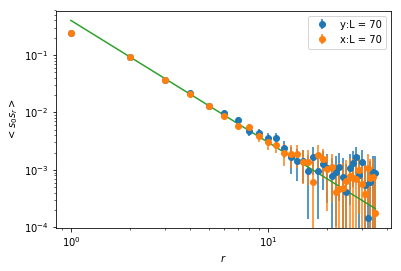

time: 684 ms


In [25]:
#Ls = [50, 60, 70, 80, 90, 100]
Ls = [70]
pl.figure()

for L in Ls:
    data = np.load('Raw data/y_L%s.npz'%L)
    x = data['x']
    y = data['y']
    pl.errorbar(x, y[:,0], y[:,1], fmt ='o', label = 'y:L = %s'%L)
    data2 = np.load('Raw data/x_L%s.npz'%L)
    x2 = data2['x']
    y2 = data2['y']
    pl.errorbar(x2, y2[:,0], y2[:,1], fmt ='o', label = 'x:L = %s'%L)

pl.plot(np.linspace(1,L//2), fit(np.linspace(1,L//2), Parms[0], Parms[1]))
pl.legend()
pl.xlabel('$r$')
pl.xscale('log')
#pl.xlim(10, 20)
pl.ylabel('$<s_0 s_r>$')
pl.yscale('log')
#pl.ylim(-0.01, 0.01)
pl.show()

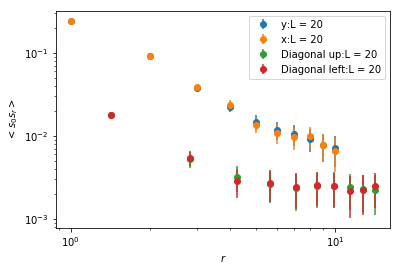

time: 390 ms


In [25]:
#Diagonal vs Straight
Ls = [20]
pl.figure()

for L in Ls:
    data = np.load('Raw data/y_L%s.npz'%L)
    x = data['x']
    y = data['y']
    pl.errorbar(x, y[:,0], y[:,1], fmt ='o', label = 'y:L = %s'%L)
    data2 = np.load('Raw data/x_L%s.npz'%L)
    x2 = data2['x']
    y2 = data2['y']
    pl.errorbar(x2, y2[:,0], y2[:,1], fmt ='o', label = 'x:L = %s'%L)
    data3 = np.load('Raw data/diag_L%s_dir0.npz'%L)
    x3 = data3['x']
    y3 = data3['y']
    pl.errorbar(x3, y3[:,0], y3[:,1], fmt ='o', label = 'Diagonal up:L = %s'%L)
    data4 = np.load('Raw data/diag_L%s_dir1.npz'%L)
    x4 = data4['x']
    y4 = data4['y']
    pl.errorbar(x4, y4[:,0], y4[:,1], fmt ='o', label = 'Diagonal left:L = %s'%L)
    

#pl.plot(np.linspace(1,L//2), fit(np.linspace(1,L//2), Parms[0], Parms[1]))
pl.legend()
pl.xlabel('$r$')
pl.xscale('log')
#pl.xlim(10, 20)
pl.ylabel('$<s_0 s_r>$')
pl.yscale('log')
#pl.ylim(-0.01, 0.01)
pl.show()

New max_size: 50
New max_size: 25
New max_size: 12


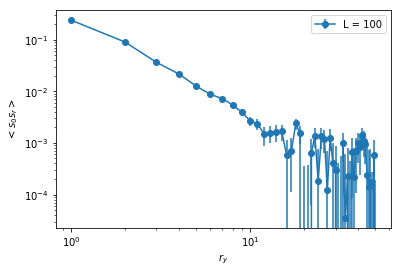

time: 1h 59min 22s


In [116]:
Ls = [60, 70, 80]

pl.figure()

for L in Ls: 
    N_iter = 300*L**2
    Rs, Corrs, MaxSize = run_simulation(L, L, N_iter, n0 =0, run_all= True)
    np.savez('Raw data/y_L%s_N%s_MaxSize%s'%(L, N_iter, MaxSize), x = Rs, y = Corrs)
    pl.errorbar(Rs, Corrs[:,0], Corrs[:,1], marker ='o', label = 'L = %s'%L)
    
pl.legend()
pl.xlabel('$r_y$')
pl.xscale('log')
pl.ylabel('$<s_0 s_r>$')
pl.yscale('log')
pl.show()

New max_size: 450
New max_size: 450
New max_size: 800
New max_size: 400
New max_size: 200
New max_size: 800
New max_size: 400
New max_size: 200


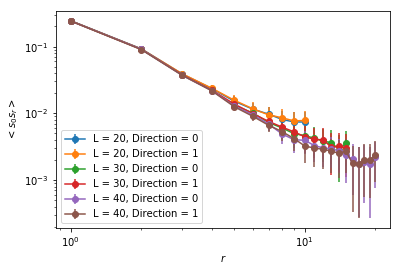

time: 22min 44s


In [14]:
Ls = [20, 30, 40]

pl.figure()

for L in Ls:
    for n0 in [0,1]:
        N_iter = 300*L**2
        Rs, Corrs, MaxSize = run_simulation(L, L, N_iter, n0 =n0, run_all= True, max_size = L**2)
        if n0 == 0:
            np.savez('Raw data/y_L%s_N%s_MaxSize%s'%(L, N_iter, MaxSize), x = Rs, y = Corrs)
        elif n0 == 1:
            np.savez('Raw data/x_L%s_N%s_MaxSize%s'%(L, N_iter, MaxSize), x = Rs, y = Corrs)
        pl.errorbar(Rs, Corrs[:,0], Corrs[:,1], marker ='o', label = 'L = %s, Direction = %s'%(L,n0))
    
pl.legend()
pl.xlabel('$r$')
pl.xscale('log')
pl.ylabel('$<s_0 s_r>$')
pl.yscale('log')
pl.show()

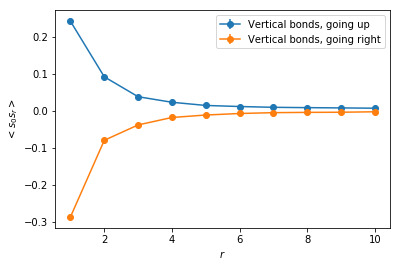

time: 1min 6s


In [20]:
L = 20

pl.figure()

N_iter = 1000*L**2
Rs, Corrs, MaxSize = run_simulation(L, L, N_iter, n0 =0, run_all= True, inv = False, max_size = L**2)
np.savez('Raw data/x_L%s_N%s_MaxSize%s'%(L, N_iter, MaxSize), x = Rs, y = Corrs)
pl.errorbar(Rs, Corrs[:,0], Corrs[:,1], marker ='o', label = 'Vertical bonds, going up')

Rs, Corrs, MaxSize = run_simulation(L, L, N_iter, n0 =0, run_all= True, inv = True, max_size = L**2)
#np.savez('Raw data/x_L%s_N%s_MaxSize%s'%(L, N_iter, MaxSize), x = Rs, y = Corrs)
pl.errorbar(Rs, np.abs(Corrs[:,0]), Corrs[:,1], marker ='o', label = 'Vertical bonds, going right')
    
pl.legend()
pl.xlabel('$r$')
pl.xscale('log')
pl.ylabel('$<s_0 s_r>$')
pl.yscale('log')
pl.show()

New max_size: 800
New max_size: 400
New max_size: 200
New max_size: 100
New max_size: 50
New max_size: 800
New max_size: 400
New max_size: 200
New max_size: 100
New max_size: 50


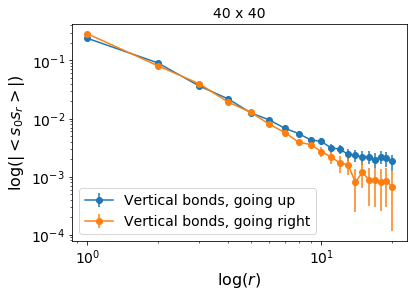

time: 1h 6min 21s


In [61]:
L = 40

#pl.figure(figsize=(12,8))
pl.figure()

N_iter = 2000*L**2
Rs, Corrs, MaxSize = run_simulation(L, L, N_iter, n0 =0, run_all= True, inv = False, max_size = L**2)
np.savez('L40_v', x = Rs, y = Corrs)
pl.errorbar(Rs, Corrs[:,0], Corrs[:,1], marker ='o', label = 'Vertical bonds, going up')

Rs, Corrs, MaxSize = run_simulation(L, L, N_iter, n0 =0, run_all= True, inv = True, max_size = L**2)
np.savez('L40_h', x = Rs, y = Corrs)
pl.errorbar(Rs, np.abs(Corrs[:,0]), Corrs[:,1], marker ='o', label = 'Vertical bonds, going right')


pl.legend(fontsize = 14)
pl.title('40 x 40', fontsize = 14)
pl.xlabel('log($r$)', fontsize=16)
pl.xticks(fontsize=14)
pl.xscale('log')
pl.ylabel('log$(|<s_0 s_r>|)$', fontsize = 16)
pl.yticks(fontsize=14)
pl.yscale('log')
#pl.savefig('L20_log.png')
pl.show()

New max_size: 800
New max_size: 400
New max_size: 200
New max_size: 800
New max_size: 400
New max_size: 200


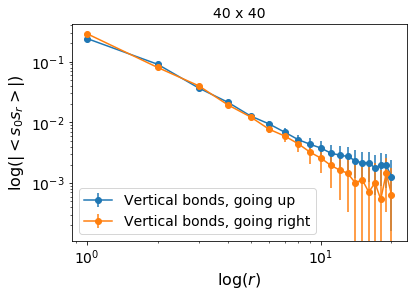

time: 25min 26s


In [62]:
L = 40

#pl.figure(figsize=(12,8))
pl.figure()

N_iter = 500*L**2
Rs, Corrs, MaxSize = run_simulation(L, L, N_iter, n0 =0, run_all= True, inv = False, max_size = L**2)
#np.savez('L40_v', x = Rs, y = Corrs)
pl.errorbar(Rs, Corrs[:,0], Corrs[:,1], marker ='o', label = 'Vertical bonds, going up')

Rs, Corrs, MaxSize = run_simulation(L, L, N_iter, n0 =0, run_all= True, inv = True, max_size = L**2)
#np.savez('L40_h', x = Rs, y = Corrs)
pl.errorbar(Rs, np.abs(Corrs[:,0]), Corrs[:,1], marker ='o', label = 'Vertical bonds, going right')


pl.legend(fontsize = 14)
pl.title('40 x 40', fontsize = 14)
pl.xlabel('log($r$)', fontsize=16)
pl.xticks(fontsize=14)
pl.xscale('log')
pl.ylabel('log$(|<s_0 s_r>|)$', fontsize = 16)
pl.yticks(fontsize=14)
pl.yscale('log')
#pl.savefig('L20_log.png')
pl.show()

Vertical: [2.02494539 0.37513494] [0.06784849 0.02125813]
Horizontal: [ 2.09718341 -0.34527057] [0.0792771  0.02329213]
Diagonal: [1.65250286 0.03087325] [0.05328627 0.00082673]


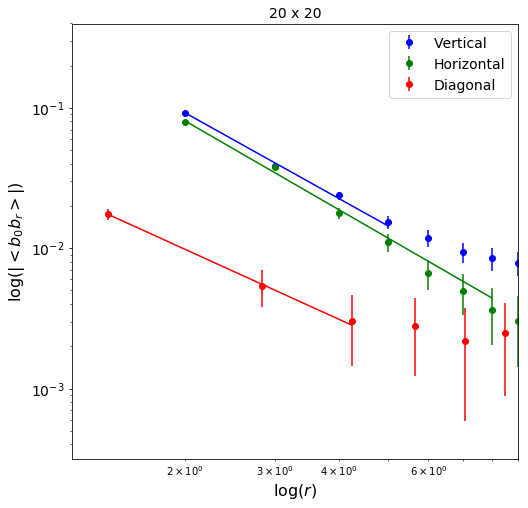

time: 844 ms


In [102]:
L = 20

pl.figure(figsize=(12,8))
#pl.figure()

data = np.load('L%s_v.npz'%L)
Rs = data['x']
Corrs = data['y']
pl.errorbar(Rs, np.abs(Corrs[:,0]), Corrs[:,1], fmt ='bo', label = 'Vertical')

x = data['x'][1:5]
y = data['y'][:,0][1:5]
sigma_y = data['y'][:,1][1:5]
params, params_covariance = optimize.curve_fit(fit, x, y, sigma = sigma_y)

print('Vertical:', params, np.sqrt(np.diag(params_covariance)))


pl.plot(np.linspace(2,5), fit(np.linspace(2,5), params[0], params[1]), color = 'b')


data = np.load('L%s_h.npz'%L)
Rs = data['x']
Corrs = data['y']
pl.errorbar(Rs, np.abs(Corrs[:,0]), Corrs[:,1], fmt ='go', label = 'Horizontal')

x = data['x'][1:8]
y = data['y'][:,0][1:8]
sigma_y = data['y'][:,1][1:8]
params, params_covariance = optimize.curve_fit(fit, x, y, sigma = sigma_y)

print('Horizontal:', params, np.sqrt(np.diag(params_covariance)))


pl.plot(np.linspace(2,8), fit(np.linspace(2,8), params[0], -params[1]), color = 'g')


data = np.load('L%s_d.npz'%L)
Rs = data['x']
Corrs = data['y']
pl.errorbar(Rs, np.abs(Corrs[:,0]), Corrs[:,1], fmt ='ro', label = 'Diagonal')

x = data['x'][:3]
y = data['y'][:,0][:3]
sigma_y = data['y'][:,1][:3]
params, params_covariance = optimize.curve_fit(fit, x, y, sigma = sigma_y)

print('Diagonal:', params, np.sqrt(np.diag(params_covariance)))

pl.plot(np.linspace(np.sqrt(2),3*np.sqrt(2)),
        fit(np.linspace(np.sqrt(2),3*np.sqrt(2)), params[0], params[1]), color = 'r')

pl.legend(fontsize = 14)
pl.title('%s x %s'%(L,L), fontsize = 14)

pl.xticks(fontsize=14)
pl.yticks(fontsize=14)

#pl.xlabel('$r$', fontsize=16)
#pl.ylabel('$<b_0 b_r>$', fontsize = 16)
#pl.savefig('L%s.png'%L)

pl.xscale('log')
pl.xlabel('log($r$)', fontsize=16)
pl.yscale('log')

pl.ylabel('log$(|<b_0 b_r>|)$', fontsize = 16)
#pl.savefig('L%s_log.png'%L)

pl.xlim(1.2,9)
pl.savefig('L%s_fit.png'%L)

pl.show()

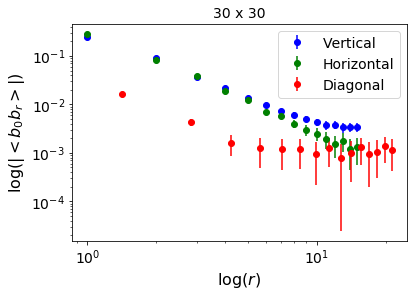

time: 532 ms


In [104]:
L = 30

#pl.figure(figsize=(12,8))
pl.figure()

data = np.load('L%s_v.npz'%L)
Rs = data['x']
Corrs = data['y']
pl.errorbar(Rs, np.abs(Corrs[:,0]), Corrs[:,1], fmt ='bo', label = 'Vertical')

'''x = data['x'][1:5]
y = data['y'][:,0][1:5]
sigma_y = data['y'][:,1][1:5]
params, params_covariance = optimize.curve_fit(fit, x, y, sigma = sigma_y)

print('Vertical:', params, np.sqrt(np.diag(params_covariance)))


pl.plot(np.linspace(2,5), fit(np.linspace(2,5), params[0], params[1]), color = 'b')'''


data = np.load('L%s_h.npz'%L)
Rs = data['x']
Corrs = data['y']
pl.errorbar(Rs, np.abs(Corrs[:,0]), Corrs[:,1], fmt ='go', label = 'Horizontal')

'''x = data['x'][1:8]
y = data['y'][:,0][1:8]
sigma_y = data['y'][:,1][1:8]
params, params_covariance = optimize.curve_fit(fit, x, y, sigma = sigma_y)

print('Horizontal:', params, np.sqrt(np.diag(params_covariance)))


pl.plot(np.linspace(2,8), fit(np.linspace(2,8), params[0], -params[1]), color = 'g')
'''

data = np.load('L%s_d.npz'%L)
Rs = data['x']
Corrs = data['y']
pl.errorbar(Rs, np.abs(Corrs[:,0]), Corrs[:,1], fmt ='ro', label = 'Diagonal')

'''x = data['x'][:3]
y = data['y'][:,0][:3]
sigma_y = data['y'][:,1][:3]
params, params_covariance = optimize.curve_fit(fit, x, y, sigma = sigma_y)

print('Diagonal:', params, np.sqrt(np.diag(params_covariance)))

pl.plot(np.linspace(np.sqrt(2),3*np.sqrt(2)),
        fit(np.linspace(np.sqrt(2),3*np.sqrt(2)), params[0], params[1]), color = 'r')

'''
pl.legend(fontsize = 14)
pl.title('%s x %s'%(L,L), fontsize = 14)

pl.xticks(fontsize=14)
pl.yticks(fontsize=14)

#pl.xlabel('$r$', fontsize=16)
#pl.ylabel('$<b_0 b_r>$', fontsize = 16)
#pl.savefig('L%s.png'%L)

pl.xscale('log')
pl.xlabel('log($r$)', fontsize=16)
pl.yscale('log')

pl.ylabel('log$(|<b_0 b_r>|)$', fontsize = 16)
#pl.savefig('L%s_log.png'%L)

#pl.xlim(1.2,9)
#pl.savefig('L%s_fit.png'%L)

pl.show()

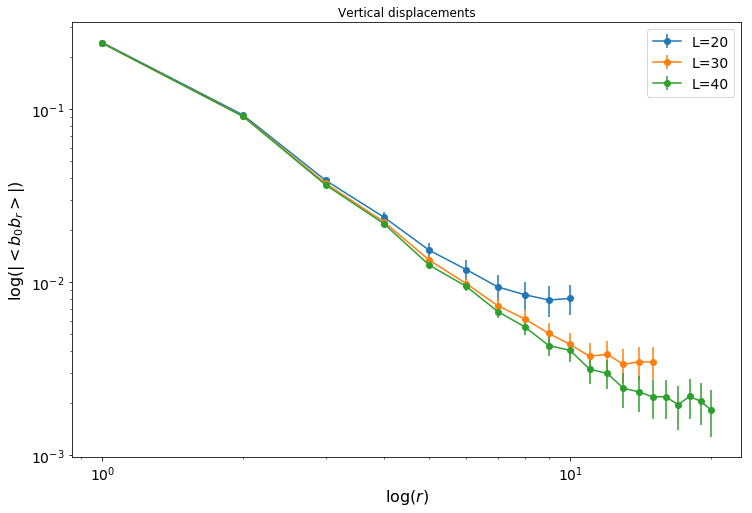

time: 519 ms


In [119]:
pl.figure(figsize=(12,8))

for L in [20,30,40]:

    data = np.load('L%s_v.npz'%L)
    Rs = data['x']
    Corrs = data['y']
    pl.errorbar(Rs, np.abs(Corrs[:,0]), Corrs[:,1], fmt='-o', label = 'L=%s'%L)
    
''' data = np.load('L%s_h.npz'%L)
    Rs = data['x']
    Corrs = data['y']
    pl.errorbar(Rs, np.abs(Corrs[:,0]), Corrs[:,1], label = 'Horizontal (L=%s)'%L)
'''
'''x = data['x'][:3]
y = data['y'][:,0][:3]
sigma_y = data['y'][:,1][:3]
params, params_covariance = optimize.curve_fit(fit, x, y, sigma = sigma_y)

print('Diagonal:', params, np.sqrt(np.diag(params_covariance)))

pl.plot(np.linspace(np.sqrt(2),3*np.sqrt(2)),
        fit(np.linspace(np.sqrt(2),3*np.sqrt(2)), params[0], params[1]), color = 'r')
'''

pl.legend(fontsize = 14)
#pl.title('%s x %s'%(L,L), fontsize = 14)
pl.title('Vertical displacements')

pl.xticks(fontsize=14)
pl.yticks(fontsize=14)

#pl.xlabel('$r$', fontsize=16)
#pl.ylabel('$<b_0 b_r>$', fontsize = 16)
#pl.savefig('L%s.png'%L)

pl.xscale('log')
pl.xlabel('log($r$)', fontsize=16)
pl.yscale('log')

pl.ylabel('log$(|<b_0 b_r>|)$', fontsize = 16)
#pl.savefig('L%s_log.png'%L)

#pl.xlim(1.2,7)
pl.savefig('Vertical.png')

pl.show()

Fit results: [1.59703838 0.24227225] [0.10176666 0.00796364]


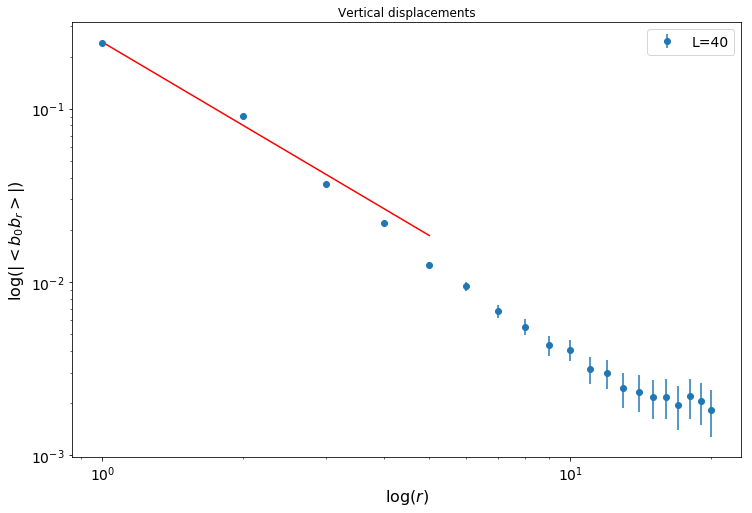

time: 448 ms


In [138]:
pl.figure(figsize=(12,8))

L = 40

data = np.load('L%s_v.npz'%L)
Rs = data['x']
Corrs = data['y']
pl.errorbar(Rs, np.abs(Corrs[:,0]), Corrs[:,1], fmt='o', label = 'L=%s'%L)

mini = 0
maxi = 5

x = data['x'][mini:maxi]
y = data['y'][:,0][mini:maxi]
sigma_y = data['y'][:,1][mini:maxi]
params, params_covariance = optimize.curve_fit(fit, x, y, sigma = sigma_y)

print('Fit results:', params, np.sqrt(np.diag(params_covariance)))

pl.plot(np.linspace(mini+1,maxi), fit(np.linspace(mini+1,maxi), params[0], params[1]), color = 'r')

pl.legend(fontsize = 14)
#pl.title('%s x %s'%(L,L), fontsize = 14)
pl.title('Vertical displacements')

pl.xticks(fontsize=14)
pl.yticks(fontsize=14)

#pl.xlabel('$r$', fontsize=16)
#pl.ylabel('$<b_0 b_r>$', fontsize = 16)
#pl.savefig('L%s.png'%L)

pl.xscale('log')
pl.xlabel('log($r$)', fontsize=16)
pl.yscale('log')

pl.ylabel('log$(|<b_0 b_r>|)$', fontsize = 16)
#pl.savefig('L%s_log.png'%L)

#pl.xlim(1.2,7)
#pl.savefig('Vertical.png')

pl.show()

Fit results: [1.98722732 0.03208718] [0.06550271 0.00097723]


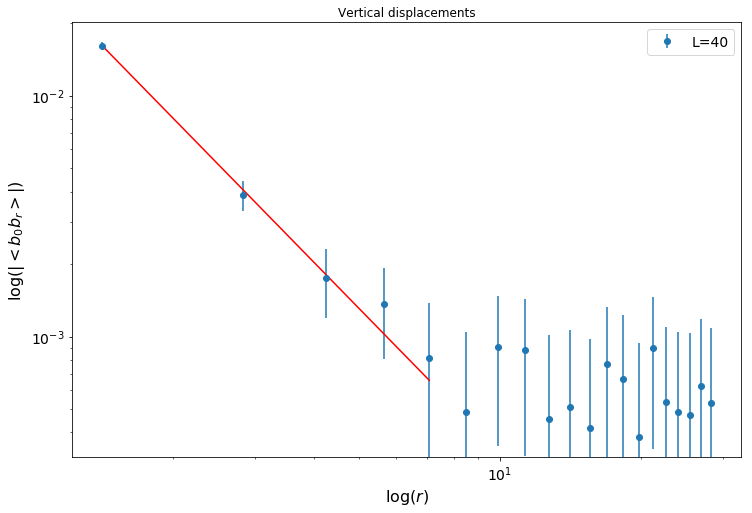

time: 471 ms


In [139]:
pl.figure(figsize=(12,8))

L = 40

data = np.load('L%s_d.npz'%L)
Rs = data['x']
Corrs = data['y']
pl.errorbar(Rs, np.abs(Corrs[:,0]), Corrs[:,1], fmt='o', label = 'L=%s'%L)

mini = 0
maxi = 5

x = data['x'][mini:maxi]
y = data['y'][:,0][mini:maxi]
sigma_y = data['y'][:,1][mini:maxi]
params, params_covariance = optimize.curve_fit(fit, x, y, sigma = sigma_y)

print('Fit results:', params, np.sqrt(np.diag(params_covariance)))

pl.plot(np.linspace(np.sqrt(2),maxi*np.sqrt(2)),
        fit(np.linspace(np.sqrt(2),maxi*np.sqrt(2)), params[0], params[1]), color = 'r')

pl.legend(fontsize = 14)
#pl.title('%s x %s'%(L,L), fontsize = 14)
pl.title('Vertical displacements')

pl.xticks(fontsize=14)
pl.yticks(fontsize=14)

#pl.xlabel('$r$', fontsize=16)
#pl.ylabel('$<b_0 b_r>$', fontsize = 16)
#pl.savefig('L%s.png'%L)

pl.xscale('log')
pl.xlabel('log($r$)', fontsize=16)
pl.yscale('log')

pl.ylabel('log$(|<b_0 b_r>|)$', fontsize = 16)
#pl.savefig('L%s_log.png'%L)

#pl.xlim(1.2,7)
#pl.savefig('Vertical.png')

pl.show()

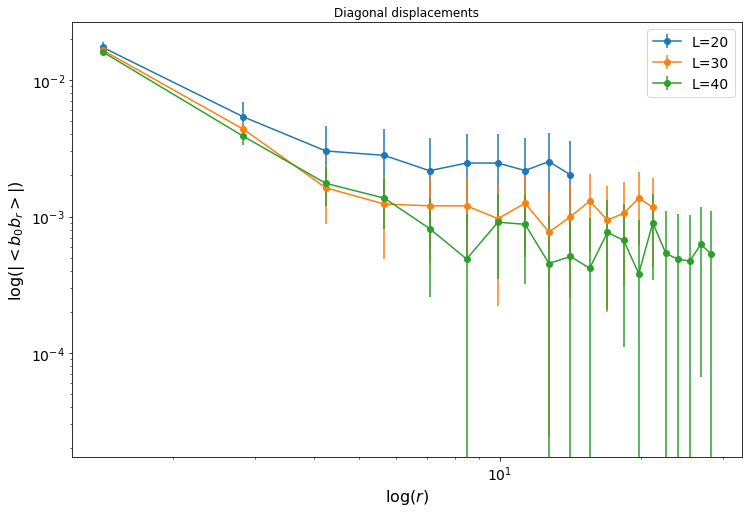

time: 585 ms


In [121]:
pl.figure(figsize=(12,8))

for L in [20,30,40]:

    data = np.load('L%s_h.npz'%L)
    Rs = data['x']
    Corrs = data['y']
    pl.errorbar(Rs, np.abs(Corrs[:,0]), Corrs[:,1],fmt='-o', label = 'L=%s'%L)
    
'''x = data['x'][:3]
y = data['y'][:,0][:3]
sigma_y = data['y'][:,1][:3]
params, params_covariance = optimize.curve_fit(fit, x, y, sigma = sigma_y)

print('Diagonal:', params, np.sqrt(np.diag(params_covariance)))

pl.plot(np.linspace(np.sqrt(2),3*np.sqrt(2)),
        fit(np.linspace(np.sqrt(2),3*np.sqrt(2)), params[0], params[1]), color = 'r')
'''

pl.legend(fontsize = 14)
#pl.title('%s x %s'%(L,L), fontsize = 14)
pl.title('Horizontal displacements')

pl.xticks(fontsize=14)
pl.yticks(fontsize=14)

#pl.xlabel('$r$', fontsize=16)
#pl.ylabel('$<b_0 b_r>$', fontsize = 16)
#pl.savefig('L%s.png'%L)

pl.xscale('log')
pl.xlabel('log($r$)', fontsize=16)
pl.yscale('log')

pl.ylabel('log$(|<b_0 b_r>|)$', fontsize = 16)
#pl.savefig('L%s_log.png'%L)

#pl.xlim(1.2,7)
pl.savefig('Horizontal.png')

pl.show()

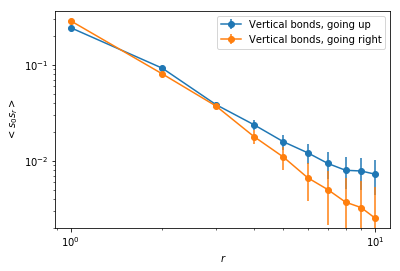

time: 1min 5s


In [21]:
L = 20

pl.figure()

N_iter = 300*L**2
Rs, Corrs, MaxSize = run_simulation(L, L, N_iter, n0 =0, run_all= True, inv = False, max_size = L**2)
#np.savez('Raw data/x_L%s_N%s_MaxSize%s'%(L, N_iter, MaxSize), x = Rs, y = Corrs)
pl.errorbar(Rs, Corrs[:,0], Corrs[:,1], marker ='o', label = 'Vertical bonds, going up')

Rs, Corrs, MaxSize = run_simulation(L, L, N_iter, n0 =0, run_all= True, inv = True, max_size = L**2)
#np.savez('Raw data/x_L%s_N%s_MaxSize%s'%(L, N_iter, MaxSize), x = Rs, y = Corrs)
pl.errorbar(Rs, np.abs(Corrs[:,0]), Corrs[:,1], marker ='o', label = 'Vertical bonds, going right')
    
pl.legend()
pl.xlabel('$r$')
pl.xscale('log')
pl.ylabel('$<s_0 s_r>$')
pl.yscale('log')
pl.show()

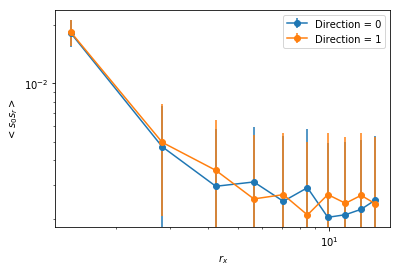

time: 1min 16s


In [83]:
L = 20

pl.figure()

for n0 in [0,1]: 
    N_iter = 300*L**2
    Rs, Corrs, MaxSize = run_simulation(L, L, N_iter, n0 =n0, run_all= True, diag = True,
                                        max_size = L**2)
    #np.savez('Raw data/x_L%s_N%s_MaxSize%s'%(L, N_iter, MaxSize), x = Rs, y = Corrs)
    pl.errorbar(Rs, Corrs[:,0], Corrs[:,1], marker ='o', label = 'Direction = %s'%n0)
    
pl.legend()
pl.xlabel('$r_x$')
pl.xscale('log')
pl.ylabel('$<s_0 s_r>$')
pl.yscale('log')
pl.show()

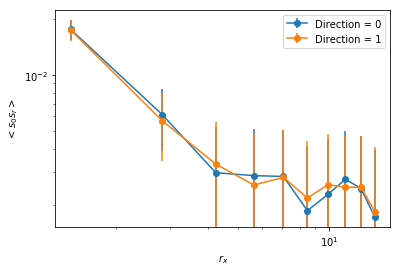

time: 2min 48s


In [84]:
L = 20

pl.figure()

for n0 in [0,1]: 
    N_iter = 500*L**2
    Rs, Corrs, MaxSize = run_simulation(L, L, N_iter, n0 =n0, run_all= True, diag = True,
                                        max_size= L**2)
    #np.savez('Raw data/x_L%s_N%s_MaxSize%s'%(L, N_iter, MaxSize), x = Rs, y = Corrs)
    pl.errorbar(Rs, Corrs[:,0], Corrs[:,1], marker ='o', label = 'Direction = %s'%n0)
    
pl.legend()
pl.xlabel('$r_x$')
pl.xscale('log')
pl.ylabel('$<s_0 s_r>$')
pl.yscale('log')
pl.show()

New max_size: 450
New max_size: 225
New max_size: 450
New max_size: 225
New max_size: 800
New max_size: 400
New max_size: 200
New max_size: 100
New max_size: 800
New max_size: 400
New max_size: 200
New max_size: 100


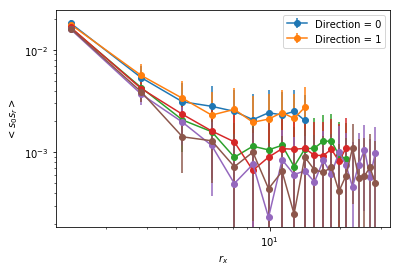

time: 1h 1min 46s


In [15]:
Ls = [20, 30, 40]

pl.figure()

for L in Ls:
    for n0 in [0,1]: 
        N_iter = 1000*L**2
        Rs, Corrs, MaxSize = run_simulation(L, L, N_iter, n0 =n0, run_all= True, diag = True,
                                            max_size= L**2)
        np.savez('Raw data/diag_L%s_N%s_MaxSize%s_dir%s'%(L, N_iter, MaxSize, n0), x = Rs, y = Corrs)
        pl.errorbar(Rs, Corrs[:,0], Corrs[:,1], marker ='o', label = 'Direction = %s'%n0)
    
pl.legend()
pl.xlabel('$r_x$')
pl.xscale('log')
pl.ylabel('$<s_0 s_r>$')
pl.yscale('log')
pl.show()

New max_size: 450
New max_size: 225
New max_size: 112
New max_size: 450
New max_size: 225
New max_size: 112
New max_size: 800
New max_size: 400
New max_size: 200
New max_size: 100
New max_size: 50
New max_size: 800
New max_size: 400
New max_size: 200
New max_size: 100
New max_size: 50


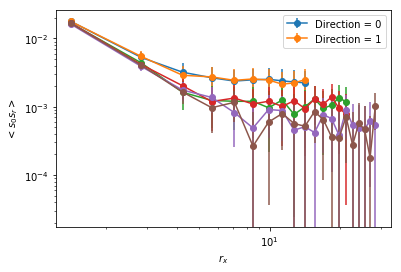

time: 3h 45min 51s


In [16]:
Ls = [20, 30, 40]

pl.figure()

for L in Ls:
    for n0 in [0,1]: 
        N_iter = 2000*L**2
        Rs, Corrs, MaxSize = run_simulation(L, L, N_iter, n0 =n0, run_all= True, diag = True,
                                            max_size= L**2)
        np.savez('Raw data/diag_L%s_N%s_MaxSize%s_dir%s'%(L, N_iter, MaxSize, n0), x = Rs, y = Corrs)
        pl.errorbar(Rs, Corrs[:,0], Corrs[:,1], marker ='o', label = 'Direction = %s'%n0)
    
pl.legend()
pl.xlabel('$r_x$')
pl.xscale('log')
pl.ylabel('$<s_0 s_r>$')
pl.yscale('log')
pl.show()

(1, 15, 2)
[[0.23436667 0.00177489]
 [0.08974667 0.00181837]
 [0.04354    0.00182401]
 [0.02068667 0.00182535]
 [0.00862    0.00182567]
 [0.00814667 0.00182568]
 [0.00696667 0.0018257 ]
 [0.00791333 0.00182568]
 [0.00825333 0.00182568]
 [0.00414667 0.00182573]
 [0.0077     0.00182569]
 [0.00326    0.00182573]
 [0.01842    0.00182543]
 [0.00520667 0.00182572]
 [0.00634    0.00182571]]
(30, 15, 2)


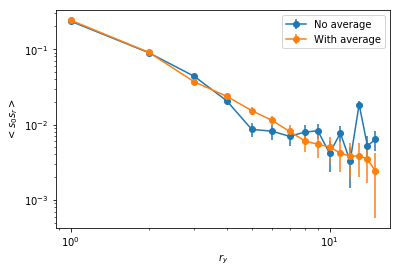

In [128]:
L = 30
N_iter = 10000*L

pl.figure()
Rs, Corrs = run_simulation(L, L, N_iter)
pl.errorbar(Rs, Corrs[:,0], Corrs[:,1], marker ='o', label = 'No average')

Rs, Corrs = run_simulation(L, L, N_iter, run_all = True)
pl.errorbar(Rs, Corrs[:,0], Corrs[:,1], marker ='o', label = 'With average')

pl.legend()
pl.xlabel('$r_y$')
pl.xscale('log')
pl.ylabel('$<s_0 s_r>$')
pl.yscale('log')
pl.show()

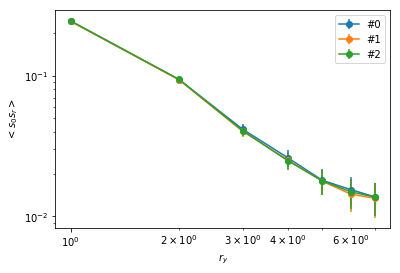

In [285]:
L = 15
N_iters = [1000, 5000, 10000]


pl.figure()

for i in range(3):
    N_iter = 5000*L
    Rs, Corrs = run_simulation(L, L, N_iter, n0 =0, run_all= True)
    pl.errorbar(Rs, Corrs[:,0], Corrs[:,1], marker ='o', label = '#%s'%i)
    
pl.legend()
pl.xlabel('$r_y$')
pl.xscale('log')
pl.ylabel('$<s_0 s_r>$')
pl.yscale('log')
pl.show()

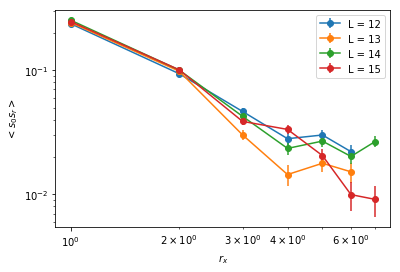

In [88]:
Ls = [12, 13, 14, 15]

pl.figure()
for L in Ls:
    N_iter = 10000*L
    Rs, Corrs = run_simulation(L, L, N_iter, n0 = L)
    pl.errorbar(Rs, Corrs[:,0], Corrs[:,1], marker ='o', label = 'L = %s'%L)
    
pl.legend()
pl.xlabel('$r_x$')
pl.xscale('log')
pl.ylabel('$<s_0 s_r>$')
pl.yscale('log')
pl.show()

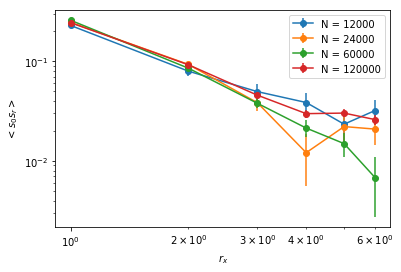

In [87]:
L = 12
N_iters = [1000, 2000, 5000, 10000]

pl.figure()
for n in N_iters:
    N_iter = n*L
    Rs, Corrs = run_simulation(L, L, N_iter, n0 = L)
    pl.errorbar(Rs, Corrs[:,0], Corrs[:,1], marker ='o', label = 'N = %s'%N_iter)
    
pl.legend()
pl.xlabel('$r_x$')
pl.xscale('log')
pl.ylabel('$<s_0 s_r>$')
pl.yscale('log')
pl.show()

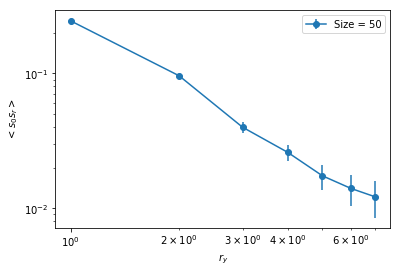

time: 9.6 s


In [115]:
max_size = 50
L = 15

pl.figure()

N_iter = 5000*L
Rs, Corrs, MaxSize = run_simulation(L, L, N_iter, n0 =0, run_all= True, max_size = max_size)
np.savez('L_%s'%L, x = Rs, y = Corrs)
pl.errorbar(Rs, Corrs[:,0], Corrs[:,1], marker ='o', label = 'Size = %s'%max_size)

pl.legend()
pl.xlabel('$r_y$')
pl.xscale('log')
pl.ylabel('$<s_0 s_r>$')
pl.yscale('log')
pl.show()